<a href="https://colab.research.google.com/github/estebanbecerra/k_brazos_BFRRCE/blob/main/notebook4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos de ascenso de gradiente en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos de ascenso de gradiente en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Author: Esteban Becerra, Carlos Cruzado, Anastasiya Ruzhytska
    Email: esteban.becerraf@um.es carlos.cruzadoe1@um.es anastasiya.r.r@um.es
    Date: 2025/02/16

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [1]:
#@title Copiar el repositorio.

!git clone https://github.com/estebanbecerra/k_brazos_BFRRCE.git
!cd k_brazos_BFRRCE/

Cloning into 'k_brazos_BFRRCE'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 347 (delta 16), reused 4 (delta 4), pack-reused 315 (from 2)
Receiving objects: 100% (347/347), 12.14 MiB | 11.76 MiB/s, done.
Resolving deltas: 100% (163/163), done.


In [2]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_BFRRCE')
sys.path.append('/content/k_brazos_BFRRCE/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, Softmax, GradientBandit
from arms import ArmNormal, ArmBinomial, ArmBernoulli, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret


['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_BFRRCE', '/content/k_brazos_BFRRCE/src']


## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos de ascenso de gradiente con diferentes valores de sus hiperparámetros. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [3]:

def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret_accumulated = np.zeros((len(algorithms), steps)) # inicializamos el rechazo acumulado para cada algoritmo
    arm_stats = [None] * len(algorithms)  # Inicializamos para almacenar al final

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.
        optimal_reward = bandit.get_expected_value(optimal_arm) # Valor esperado del brazo óptimo, se calcula una vez.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # Calcular regret acumulado
                if step == 0:
                    regret_accumulated[idx, step] = optimal_reward - current_bandit.get_expected_value(chosen_arm)  # Primera iteración
                else:
                    regret_accumulated[idx, step] = regret_accumulated[idx, step-1] + (optimal_reward - current_bandit.get_expected_value(chosen_arm))


                #TODO: modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                  optimal_selections[idx, step] += 1  # Contamos si seleccionó el óptimo


        for idx, algo in enumerate(algorithms):
            if arm_stats[idx] is None:
                arm_stats[idx] = {
                    "mean_rewards": algo.values.copy(),
                    "selection_counts": algo.counts.copy(),
                    "optimal_arm": optimal_arm
                }



    rewards /= runs

    # TODO: calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections /= runs  # Promediamos las selecciones óptimas sobre todas las ejecuciones

    return rewards, optimal_selections, regret_accumulated, arm_stats


## Ejecución del experimento y visualización de los resultados

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 2 algoritmos: softmax y gradient-bandit para valores tau: 0.1, 0.5 y 1 y alpha: 0.1, 0.4, 0.7.


Evaluando métodos de ascenso del gradiente con brazos Bernoulli...
Bandit with 10 arms: ArmBernoulli(p=0.37), ArmBernoulli(p=0.95), ArmBernoulli(p=0.73), ArmBernoulli(p=0.60), ArmBernoulli(p=0.16), ArmBernoulli(p=0.16), ArmBernoulli(p=0.06), ArmBernoulli(p=0.87), ArmBernoulli(p=0.60), ArmBernoulli(p=0.71)
Optimal arm: 2 with expected reward=0.9507143064099162

Resultados para Bernoulli:


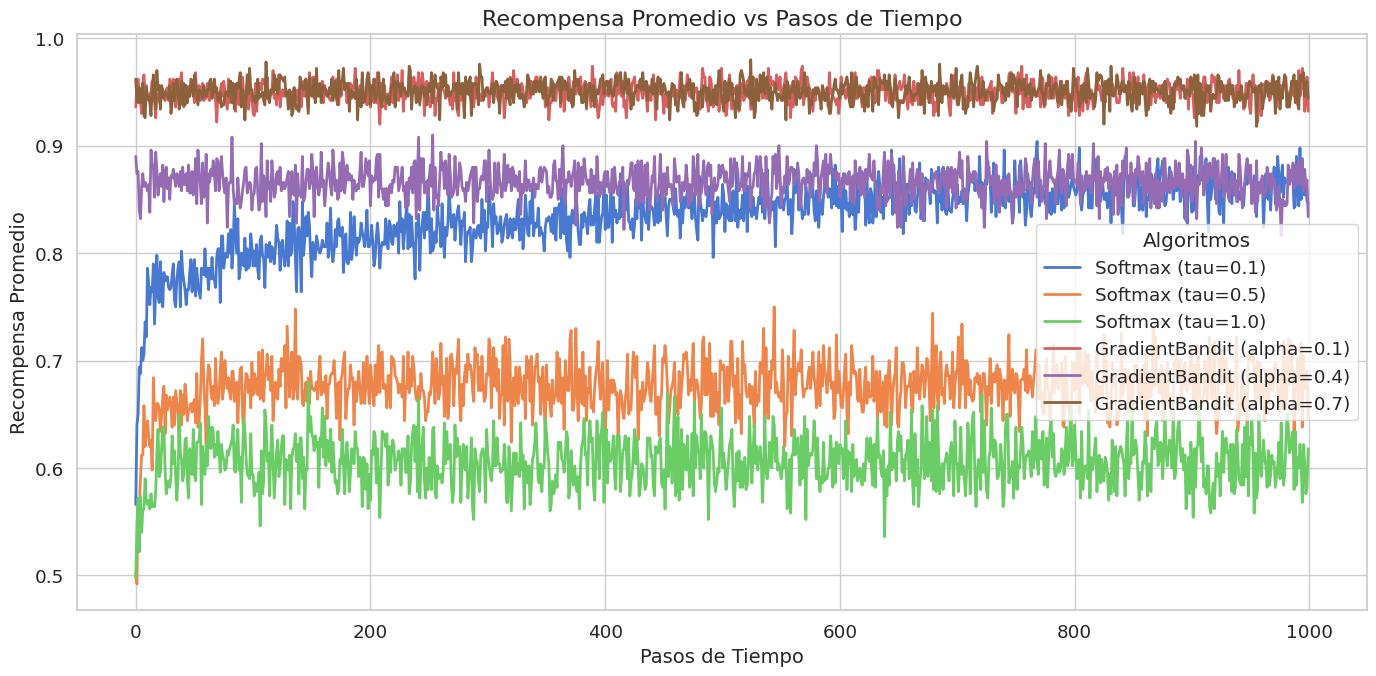

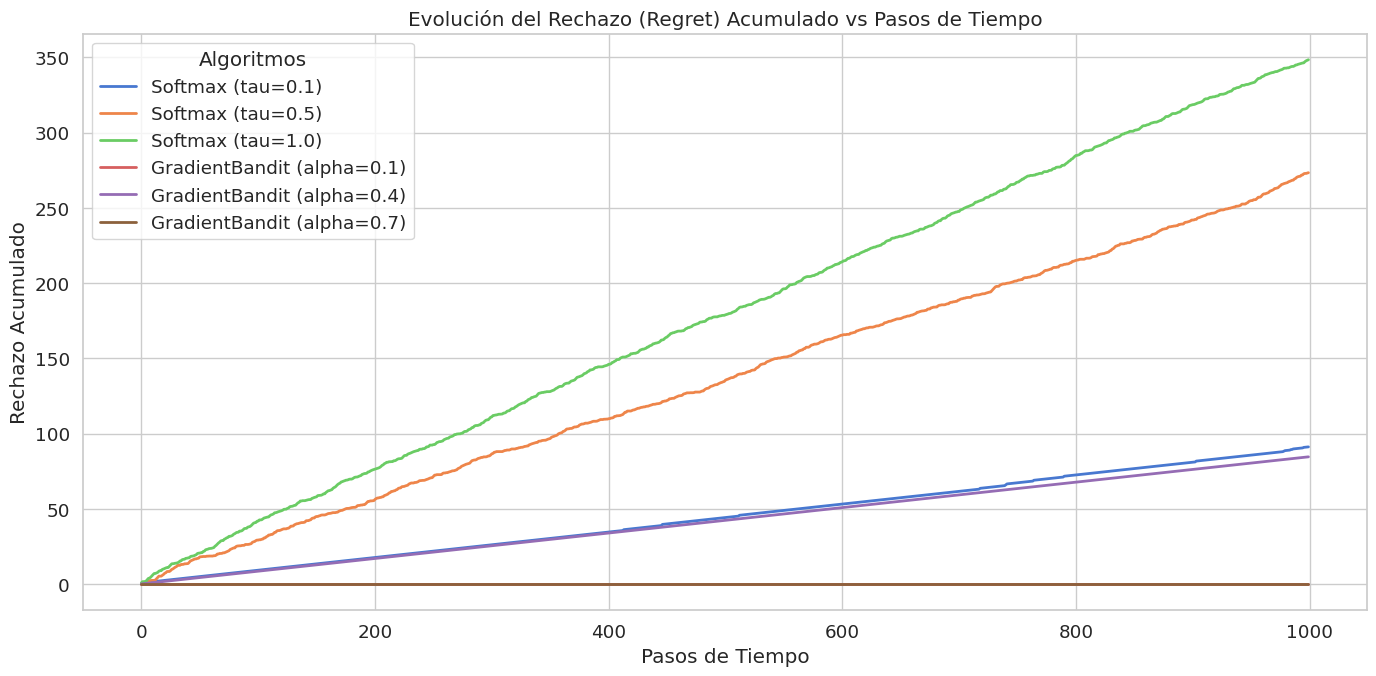


Evaluando métodos de ascenso del gradiente con brazos Binomial...
Bandit with 10 arms: ArmBinomial(n=10, p=0.32), ArmBinomial(n=10, p=0.98), ArmBinomial(n=10, p=0.10), ArmBinomial(n=10, p=0.53), ArmBinomial(n=10, p=0.90), ArmBinomial(n=10, p=0.06), ArmBinomial(n=10, p=0.63), ArmBinomial(n=10, p=0.89), ArmBinomial(n=10, p=0.15), ArmBinomial(n=10, p=0.46)
Optimal arm: 2 with expected reward=9.843707431128161

Resultados para Binomial:


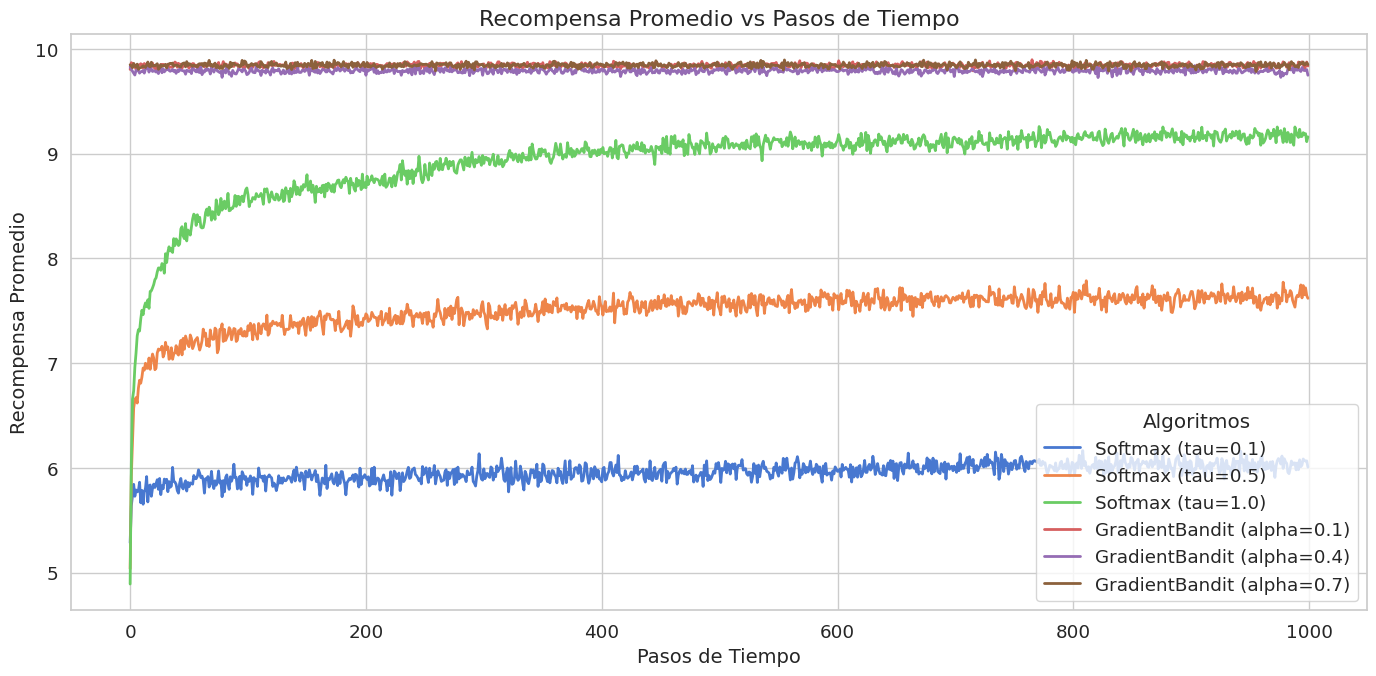

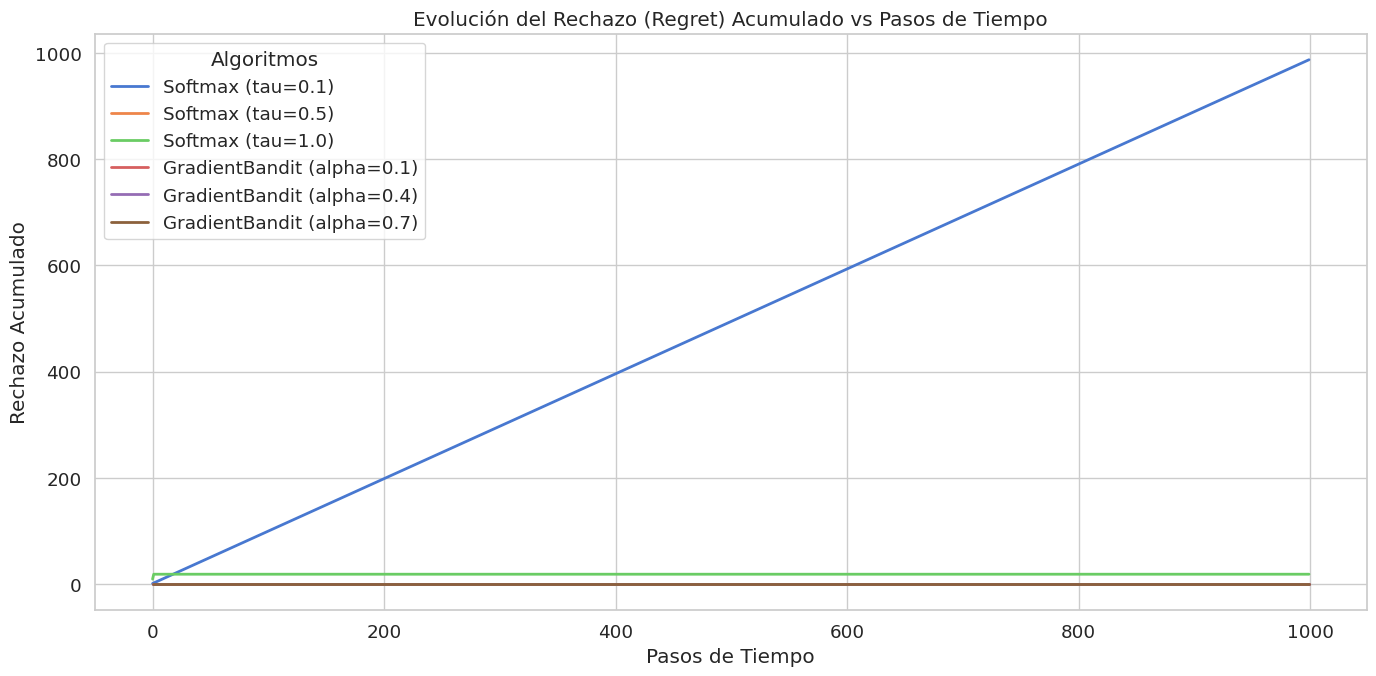


Evaluando métodos de ascenso del gradiente con brazos Normal...
Bandit with 10 arms: ArmNormal(mu=1.92, sigma=1.0), ArmNormal(mu=1.54, sigma=1.0), ArmNormal(mu=3.91, sigma=1.0), ArmNormal(mu=2.39, sigma=1.0), ArmNormal(mu=5.8, sigma=1.0), ArmNormal(mu=6.68, sigma=1.0), ArmNormal(mu=5.11, sigma=1.0), ArmNormal(mu=8.97, sigma=1.0), ArmNormal(mu=9.86, sigma=1.0), ArmNormal(mu=9.06, sigma=1.0)
Optimal arm: 9 with expected reward=9.86

Resultados para Normal:


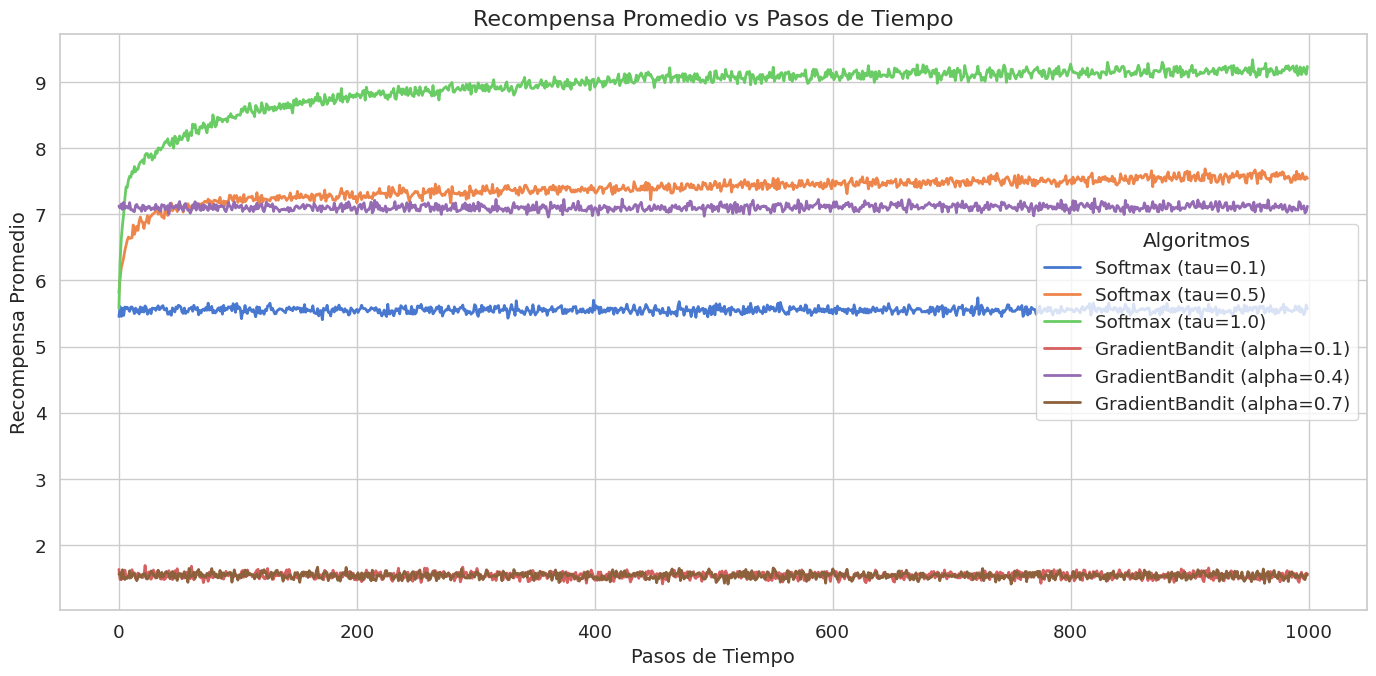

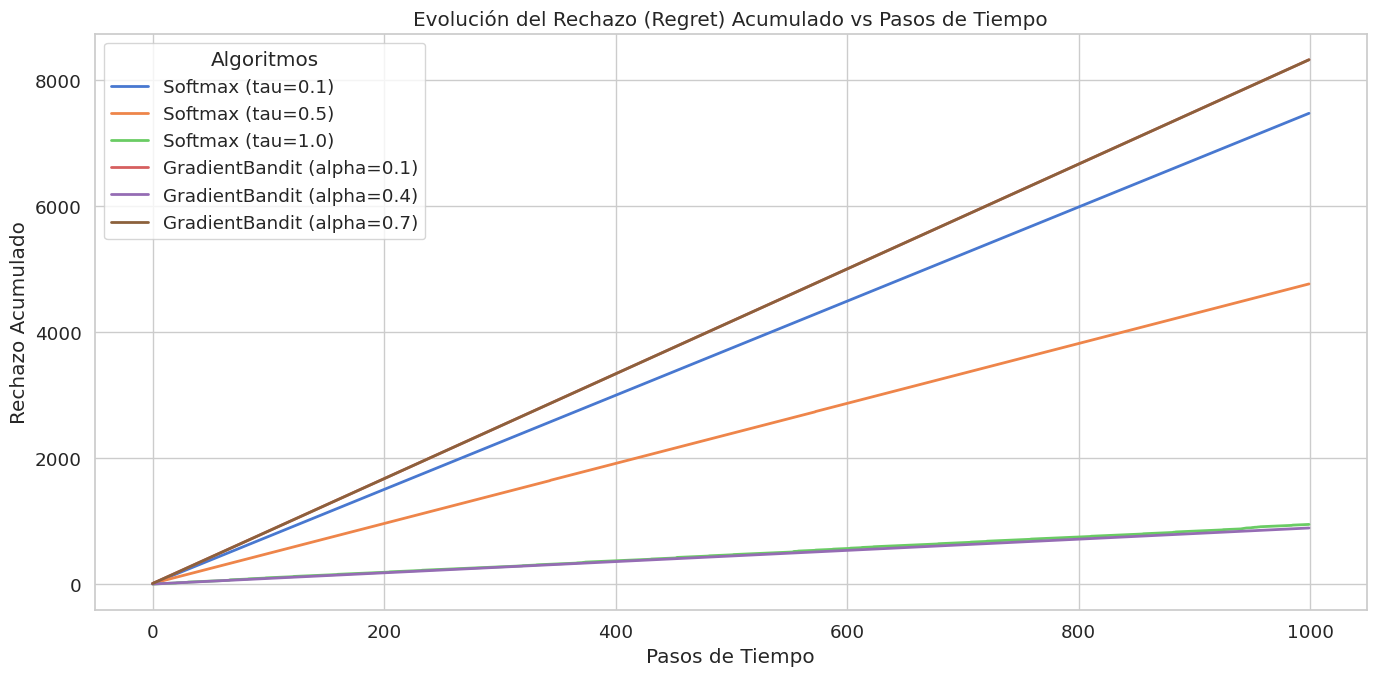

In [4]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Tipos de brazos que se van a utilizar en el experimento
arm_types = {
    'Bernoulli': ArmBernoulli,
    'Binomial': ArmBinomial,
    'Normal': ArmNormal
}

# Definir los hiperparámetros a comparar para cada algoritmo Softmax y GradientBandit
softmax_configs = [0.1, 0.5, 1.0]  # Temperaturas τ para Softmax
gradient_bandit_configs = [0.1, 0.4, 0.7]  # Tasas de aprendizaje α para GradientBandit

# Definir los algoritmos a comparar en la familia de ascenso del gradiente con diferentes configuraciones
algorithms = []

# Añadir Softmax con diferentes temperaturas τ
for tau in softmax_configs:
    algorithms.append(Softmax(k=k, tau=tau))

# Añadir GradientBandit con diferentes tasas de aprendizaje α
for alpha in gradient_bandit_configs:
    algorithms.append(GradientBandit(k=k, alpha=alpha))

# Bucle para evaluar cada tipo de brazo con los algoritmos definidos
for arm_name, ArmClass in arm_types.items():
    print(f"\nEvaluando métodos de ascenso del gradiente con brazos {arm_name}...")

    # Creación del bandit con el tipo de brazo correspondiente
    bandit = Bandit(arms=ArmClass.generate_arms(k))
    print(bandit)

    # Obtener el brazo óptimo y su recompensa esperada
    optimal_arm = bandit.optimal_arm
    print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

    # Ejecutar el experimento y obtener las recompensas promedio, selecciones óptimas, regret acumulado y estadísticas de brazos
    rewards, optimal_selections, regret_accumulated, arm_stats = run_experiment(bandit, algorithms, steps, runs)

    # Graficar los resultados específicos para este tipo de brazo
    print(f"\nResultados para {arm_name}:")
    plot_average_rewards(steps, rewards, algorithms)
    plot_regret(steps, regret_accumulated, algorithms)
    # plot_optimal_selections(steps, optimal_selections, algorithms)  # Opcional
    # plot_arm_statistics(arm_stats, algorithms)  # Opcional


### Análisis detallado de las imágenes – Métodos de Ascenso del Gradiente (Softmax y Gradient Bandit)

Los gráficos generados permiten analizar el comportamiento de los **métodos de ascenso del gradiente**: **Softmax** y **Gradient Bandit**, evaluados en un problema de **k-armed bandit** con los tres tipos de distribuciones de brazos: **Bernoulli**, **Binomial** y **Normal**.

---

## **1. Recompensa Promedio vs Pasos de Tiempo**

### **Distribución Bernoulli (Imágenes 1 y 2):**
- **Softmax (τ=0.1 - azul)**: Es el que obtiene **mejor rendimiento** dentro de Softmax, alcanzando una recompensa estable y cercana al óptimo.
- **Softmax (τ=0.5 - naranja)**: Presenta **un comportamiento intermedio**, con una recompensa aceptable pero claramente **inferior a τ=0.1**.
- **Softmax (τ=1.0 - verde)**: Es el **peor** entre los Softmax, con una recompensa **más baja y menos estable**, debido a un **exceso de exploración**.
- **GradientBandit (α=0.1, 0.7 - rojo, morado, marrón)**: esos dos valores de α muestran **resultados muy buenos**, alcanzando **rápidamente la recompensa máxima** y estabilizándose en torno al valor óptimo.

**GradientBandit** es **claramente superior** a **Softmax** en esta distribución.

---

### **Distribución Binomial (Imágenes 3 y 4):**
- **Softmax (τ=1.0 - verde)**: Es el que logra **mejor recompensa promedio**, indicando que **favorecer más exploración inicial** resulta **beneficioso** en este caso.
- **Softmax (τ=0.5 - naranja)**: Es **intermedio**, aunque **notablemente inferior a τ=1.0**.
- **Softmax (τ=0.1 - azul)**: Es **el peor**, mostrando **dificultades para alcanzar el valor óptimo** debido a **excesiva explotación prematura**.
- **GradientBandit (α=0.1, 0.4, 0.7)**: **Los tres valores son casi idénticos**, **todos alcanzan la recompensa óptima** de manera rápida y estable.

**GradientBandit** es **también superior** a **Softmax** en esta distribución.

---

### **Distribución Normal (Imágenes 5 y 6):**
- **Softmax (τ=1.0 - verde)**: Es el que **mejor recompensa obtiene**, **convergencia rápida y estable** hacia el valor óptimo.
- **Softmax (τ=0.5 - naranja)**: **Aceptable**, aunque **ligeramente inferior** al caso de **τ=1.0**.
- **Softmax (τ=0.1 - azul)**: Es el **peor**, con una recompensa **baja y lenta progresión**, **quedándose atrapado en elecciones subóptimas**.
- **GradientBandit (α=0.1, 0.7)**: **Esos valores de α fallan claramente** en esta distribución, con **recompensas bajas y estancadas**.
- **GradientBandit (α=0.4)**: **Funciona muy bien** en esta distribución, con **recompensas muy similares a softmax con τ=1.0**.

**Softmax τ=1.0 y GradientBandit α=0.4** son **son muy superiores al resto de configuraciones en normal**.

---

## **2. Evolución del Rechazo (Regret) Acumulado vs Pasos de Tiempo**

Este gráfico mide **cuánto se pierde por no seleccionar el brazo óptimo en cada paso**:

### **Distribución Bernoulli (Imágenes 1 y 2):**
- **GradientBandit (α=0.1, 0.4, 0.7)**: **Todos los valores de α muestran el menor regret acumulado**, indicando que **aprenden y convergen muy rápido** hacia el brazo óptimo.
- **Softmax (τ=0.1)**: Tiene **un regret bajo y aceptable**, pero **mayor que GradientBandit**.
- **Softmax (τ=0.5, τ=1.0)**: Muestran **un regret acumulado considerablemente mayor**, reflejando **dificultades para identificar el brazo óptimo**.

---

### **Distribución Binomial (Imágenes 3 y 4):**
- **GradientBandit (α=0.1, 0.4, 0.7)**: **De nuevo, los tres valores logran el menor regret**, mostrando **gran eficiencia en la identificación del brazo óptimo**.
- **Softmax (τ=1.0)**: **Tiene un buen comportamiento**, con **regret aceptable**.
- **Softmax (τ=0.5)**: **Regret más elevado**.
- **Softmax (τ=0.1)**: **El peor regret**, **creciendo de forma sostenida**, reflejando **poca exploración y malas decisiones iniciales**.

---

### **Distribución Normal (Imágenes 5 y 6):**
- **Softmax (τ=1.0)**: **Obtiene el menor regret acumulado**, **aprendiendo rápidamente el brazo óptimo**.
- **Softmax (τ=0.5)**: **Rendimiento aceptable**, aunque **peor que τ=1.0**.
- **Softmax (τ=0.1)**: **El peor regret**, **lineal y creciente**, mostrando que **nunca logra encontrar el óptimo**.
- **GradientBandit (α=0.1,0.7)**: **Todos fallan claramente**, con **regret acumulado muy alto**, **confirmando que este método no se adapta bien a esta distribución con esa configuración**.
- **GradientBandit (α=0.4)**: **Funciona bien**, con **regret acumulado bajo y muy similar al de Softmax (τ=1.0)**.

---

## **3. Interpretación Conjunta**

- **GradientBandit** es **excelente en distribuciones discretas (Bernoulli y Binomial)**, pero **fracasa en distribuciones con alta varianza como la Normal**.
- **Softmax** es **más flexible**, funcionando **bien en Normal y Binomial** con **τ=1.0**, pero **requiere τ=0.1 en Bernoulli**.
- **GradientBandit** es **poco sensible a α**, mientras que **Softmax** **es muy sensible a τ**, requiriendo **ajustes precisos según la distribución**.

---

## **Conclusiones Finales**

### **1. Exploración vs Explotación en Métodos de Gradiente**
- **Softmax (τ)**:
  - **τ bajo (0.1)** → **Explotación prematura**, **bueno en Bernoulli**.
  - **τ intermedio (0.5)** → **Compromiso**, pero **puede ser insuficiente**.
  - **τ alto (1.0)** → **Exploración agresiva**, **mejor opción en Normal y Binomial**.
  
- **GradientBandit (α)**:
  - **Es robusto en distribuciones discretas (Bernoulli y Binomial)**.
  - **Fracasa en distribuciones continuas (Normal) para algunos valores de α**.

---

### **2. Impacto de los Hiperparámetros**
- **Softmax (τ=1.0)** → **Generalmente mejor**, **excepto en Bernoulli, donde τ=0.1** es **superior**.
- **GradientBandit (α=0.1,0.7)** → **Robusto en Bernoulli y Binomial**, **pero no funciona en Normal con cualquier valor de α**.

---

### **3. Regret Acumulado como Métrica Clave**
- **GradientBandit** → **Menor regret en Bernoulli y Binomial**.
- **Softmax (τ=1.0)** → **Menor regret en Normal**.

---

### **4. Influencia de la Distribución de los Brazos**
- **Bernoulli** → **GradientBandit** o **Softmax (τ=0.1)**.
- **Binomial** → **GradientBandit** o **Softmax (τ=1.0)**.
- **Normal** → **Softmax (τ=1.0)**.

---

## **Conclusión General:**
**GradientBandit** es **superior en distribuciones discretas**.  
**Softmax** es **más versátil**, pero **requiere ajustar τ según la distribución**.
